# Impact of Weather on Flower Blooming in California

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Data Retrieval

This project aims to analyze how climate factors such as temperature and rainfall influence flower blooming patterns in California. The data is from the [USA National Phenology Network](https://www.usanpn.org/), which is a nationwide research initiative focused on organizing and collecting phenological data. The goal of this initiative is to support natural resource management and promote the understanding of phenology. They offer a wide range of data and information on their website, and this project focuses on phenophase observations from 2015 to the beginning of 2025 with details on location, genus and species, and observation date.

Climate data from Daymet, a research product created by the Oak Ridge National Laboratory and supported by NASA, was added to see climate details at the location and time of each phenophase observation. Daymet offers gridded estimates of daily weather variables, obtained from ground-based observations and statistical modeling techniques. The variables used in this project are minimum and maximum temperature and precipitation.

In [2]:
# Load in data
data = pd.read_csv("status_intensity_observation_data.csv")
data.head()

,Observation_ID,Update_Datetime,Site_ID,Latitude,Longitude,Elevation_in_Meters,State,Species_ID,Genus,Species,...,Kingdom,Individual_ID,Phenophase_ID,Phenophase_Description,Observation_Date,Day_of_Year,Phenophase_Status,Intensity_Category_ID,Intensity_Value,Abundance_Value
0,14143517,-9999,1051,39.326412,-120.195107,1793,CA,36,Syringa,vulgaris,...,Plantae,1227,205,Open flowers (lilac),2018-05-30,150,1,-9999,-9999,-9999
1,14143518,-9999,1051,39.326412,-120.195107,1793,CA,36,Syringa,vulgaris,...,Plantae,1227,206,Full flowering (lilac),2018-05-30,150,1,-9999,-9999,-9999
2,14143524,-9999,1051,39.326412,-120.195107,1793,CA,83,Malus,pumila,...,Plantae,1228,500,Flowers or flower buds,2018-05-30,150,1,48,-9999,-9999
3,14143525,-9999,1051,39.326412,-120.195107,1793,CA,83,Malus,pumila,...,Plantae,1228,501,Open flowers,2018-05-30,150,1,50,-9999,-9999
4,14143534,-9999,1051,39.326412,-120.195107,1793,CA,64,Amelanchier,canadensis,...,Plantae,1230,500,Flowers or flower buds,2018-05-30,150,1,48,-9999,-9999


In [3]:
# Check for null values and see column and row count
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738822 entries, 0 to 738821
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Observation_ID          738822 non-null  int64  
 1   Update_Datetime         738822 non-null  object 
 2   Site_ID                 738822 non-null  int64  
 3   Latitude                738822 non-null  float64
 4   Longitude               738822 non-null  float64
 5   Elevation_in_Meters     738822 non-null  int64  
 6   State                   738822 non-null  object 
 7   Species_ID              738822 non-null  int64  
 8   Genus                   738822 non-null  object 
 9   Species                 738822 non-null  object 
 10  Common_Name             738822 non-null  object 
 11  Kingdom                 738822 non-null  object 
 12  Individual_ID           738822 non-null  int64  
 13  Phenophase_ID           738822 non-null  int64  
 14  Phenophase_Descripti

In [4]:
# Get only the records in California
df = data[data["State"] == "CA"]

# Get relevant columns
df = data[["Latitude", "Longitude", "Species", "Common_Name", "Phenophase_Description", "Observation_Date"]]

In [5]:
# Since the Observation Dates are in strings, convert them to datetimes
df.loc[:,"Observation_Date"] = pd.to_datetime(df["Observation_Date"])
df.head()

,Latitude,Longitude,Species,Common_Name,Phenophase_Description,Observation_Date
0,39.326412,-120.195107,vulgaris,common lilac,Open flowers (lilac),2018-05-30 00:00:00
1,39.326412,-120.195107,vulgaris,common lilac,Full flowering (lilac),2018-05-30 00:00:00
2,39.326412,-120.195107,pumila,paradise apple,Flowers or flower buds,2018-05-30 00:00:00
3,39.326412,-120.195107,pumila,paradise apple,Open flowers,2018-05-30 00:00:00
4,39.326412,-120.195107,canadensis,Canadian serviceberry,Flowers or flower buds,2018-05-30 00:00:00


In [6]:
# Observe unique values in phenophase description
df["Phenophase_Description"].value_counts()

,count
Phenophase_Description,
Open flowers,334131
Flowers or flower buds,292381
Pollen release (flowers),103833
Open flowers (grasses/sedges),7895
Flower heads (grasses/sedges),275
Open flowers (lilac),105
Full flowering (lilac),104
End of flowering (lilac/honeysuckle),98


In [7]:
# Convert CSV to Parquet for faster processing
df.to_parquet("df.parquet", index=False)

df = pd.read_parquet("df.parquet")

df.head()

,Latitude,Longitude,Species,Common_Name,Phenophase_Description,Observation_Date
0,39.326412,-120.195107,vulgaris,common lilac,Open flowers (lilac),2018-05-30
1,39.326412,-120.195107,vulgaris,common lilac,Full flowering (lilac),2018-05-30
2,39.326412,-120.195107,pumila,paradise apple,Flowers or flower buds,2018-05-30
3,39.326412,-120.195107,pumila,paradise apple,Open flowers,2018-05-30
4,39.326412,-120.195107,canadensis,Canadian serviceberry,Flowers or flower buds,2018-05-30


In [8]:
# Initialize cache
climate_cache = {}

def get_daymet_data(lat, lon, date):
    """
    Fetches temperature and precipitation for a given latitude, longitude, and date.

    :param lat: Latitude of location
    :param lon: Longitude of location
    :param date: Observation date (YYYY-MM-DD)
    :return: Dictionary with temperature and precipitation
    """
    year = pd.to_datetime(date).year  # Extract year

    # Check if we already fetched this location and year
    cache_key = (lat, lon, year)
    if cache_key in climate_cache:
        return climate_cache[cache_key]

    # Daymet API Endpoint
    base_url = "https://daymet.ornl.gov/single-pixel/api/data?"
    params = {
        "lat": lat,
        "lon": lon,
        "vars": "tmax,tmin,prcp",
        "years": year,
        "format": "csv"
    }

    try:
        response = requests.get(base_url, params=params, timeout=10)
        if response.status_code == 200:
            df = pd.read_csv(io.StringIO(response.text), skiprows=6)

            # Convert day-of-year to actual date
            df["date"] = pd.to_datetime(df["year"].astype(str) + df["yday"].astype(str), format="%Y%j")

            # Find the closest matching date
            match = df[df["date"] == date]
            if not match.empty:
                temp_max = match["tmax (deg c)"].values[0]
                temp_min = match["tmin (deg c)"].values[0]
                precipitation = match["prcp (mm/day)"].values[0]
            else:
                temp_max, temp_min, precipitation = None, None, None

            # Store in cache
            climate_cache[cache_key] = {"Avg_TMax": temp_max, "Avg_TMin": temp_min, "Total_Precipitation": precipitation}
            return climate_cache[cache_key]

        else:
            return {"Avg_TMax": None, "Avg_TMin": None, "Total_Precipitation": None}

    except Exception as e:
        print(f"Error fetching data for {lat}, {lon}, {date}: {e}")
        return {"Avg_TMax": None, "Avg_TMin": None, "Total_Precipitation": None}

In [9]:
# Initialize list to store results
climate_results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    climate_info = get_daymet_data(row["Latitude"], row["Longitude"], row["Observation_Date"])
    climate_results.append(climate_info)

# Convert results to DataFrame
climate_df = pd.DataFrame(climate_results)

# Merge with original dataset
df_climate = pd.concat([df.reset_index(drop=True), climate_df.reset_index(drop=True)], axis=1)

# Save final dataset as Parquet
df_climate.to_parquet("df_pq_with_climate.parquet", index=False)

# Display final dataset sample
print(df_climate.head())


100%|██████████| 738822/738822 [17:53<00:00, 688.29it/s] 


    Latitude   Longitude     Species            Common_Name  \
0  39.326412 -120.195107    vulgaris           common lilac   
1  39.326412 -120.195107    vulgaris           common lilac   
2  39.326412 -120.195107      pumila         paradise apple   
3  39.326412 -120.195107      pumila         paradise apple   
4  39.326412 -120.195107  canadensis  Canadian serviceberry   

   Phenophase_Description Observation_Date  Avg_TMax  Avg_TMin  \
0    Open flowers (lilac)       2018-05-30     20.93      5.03   
1  Full flowering (lilac)       2018-05-30     20.93      5.03   
2  Flowers or flower buds       2018-05-30     20.93      5.03   
3            Open flowers       2018-05-30     20.93      5.03   
4  Flowers or flower buds       2018-05-30     20.93      5.03   

   Total_Precipitation  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  


In [10]:
from google.colab import files

# Download the Parquet file
files.download("df_pq_with_climate.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Remove the lilac specific observations and only focus on flower blooming phenophases
df_climate = df_climate[df_climate["Phenophase_Description"].isin(["Open flowers", "Flowers or flower buds", "Open flowers (grasses/sedges)"])]

# Flower blooming by month

<ipython-input-12-97b9c89208cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate["Month"] = df_climate["Observation_Date"].dt.month


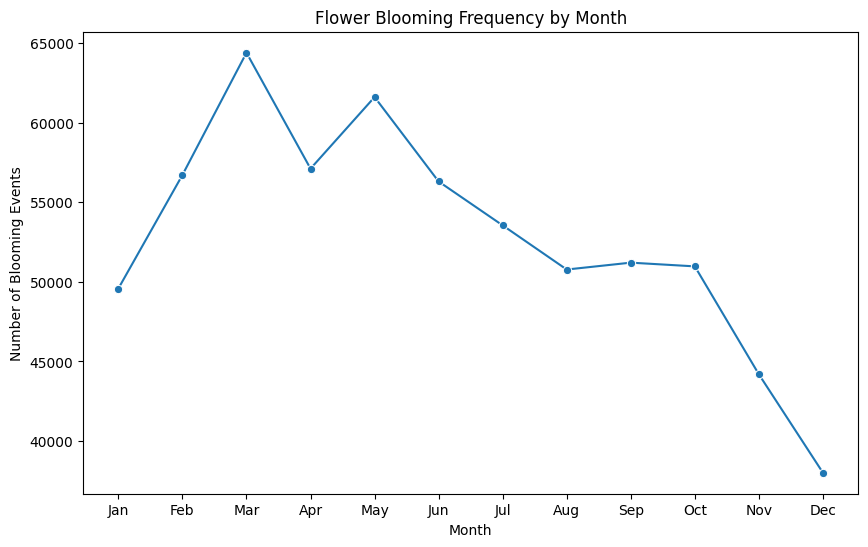

In [12]:
# Extract month
df_climate["Month"] = df_climate["Observation_Date"].dt.month

# Group by month
monthly_bloom = df_climate.groupby("Month").size()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_bloom.index, y=monthly_bloom.values, marker="o")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Flower Blooming Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Number of Blooming Events")
plt.show()

This line graph illustrates the total number of blooming events recorded across ten years of flower phenophase data, grouped by month. The data reveals a clear seasonal pattern, with blooming activity beginning to rise in January, peaking in March with nearly 65,000 events, and maintaining relatively high levels through May. After this spring peak, blooming frequency gradually declines throughout the summer and fall months, reaching its lowest point in December. This trend is consistent with typical temperate zone flowering behavior, where most species bloom in response to increasing daylight and warmer temperatures in the spring. The secondary rise in May suggests that some late-spring or early-summer species contribute significantly to blooming events. The relatively steady levels from June through October, followed by a sharper drop in November and December, highlight a slowing of blooming activity as the growing season ends. Overall, this pattern shows the strong influence of seasonal changes on flower blooming.

# Flower Blooming by Year

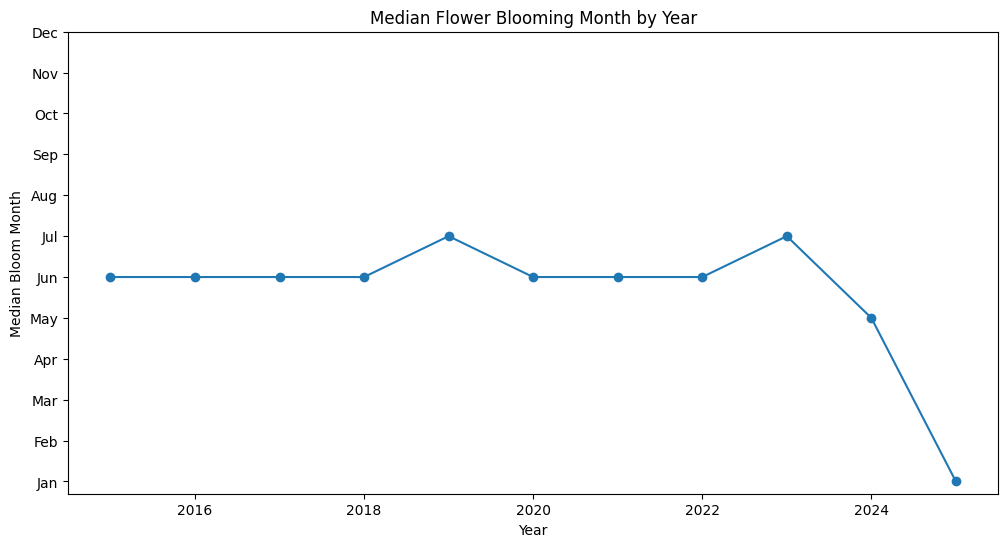

In [14]:
df_climate["Year"] = df_climate["Observation_Date"].dt.year

# Group data by year
bloom_trend = df_climate.groupby("Year")["Month"].median()

# Create the plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Bloom Trend (Median Bloom Month)
ax1.plot(bloom_trend.index, bloom_trend.values, marker="o")
ax1.set_ylabel("Median Bloom Month")
ax1.set_yticks(range(1, 13))  # Set y-axis to months
ax1.set_yticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax1.tick_params(axis='y')

# Titles and labels
plt.title("Median Flower Blooming Month by Year")
ax1.set_xlabel("Year")

plt.show()

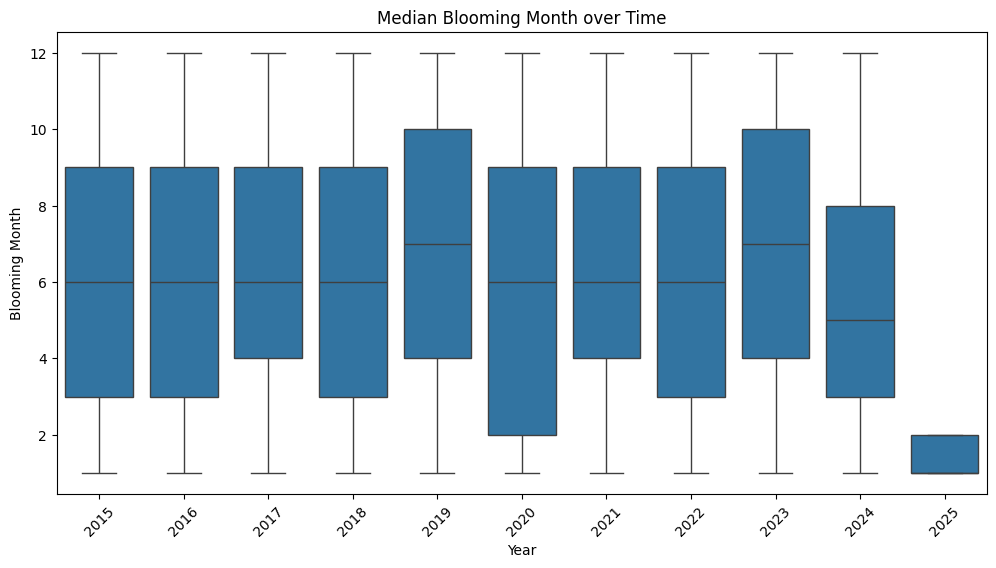

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_climate, x="Year", y="Month", showfliers=False)
plt.xticks(rotation=45)
plt.title("Median Blooming Month over Time")
plt.xlabel("Year")
plt.ylabel("Blooming Month")
plt.show()


These two plots show the median bloom month for each year from 2015 to 2025. For the first three years shown, the median bloom month remained consistently in June, suggesting stable seasonal flowering patterns during those years. However, there was a shift with the median bloom month rising to July in 2019 and 2023 before stabilizing to June again. There was a dip in 2024 to May, and the sharp dip into January in 2025 is due to a lack of data. This shift in 2024 suggests a potential response to unseasonably warm winter conditions, supporting the hypothesis that flowers may be blooming earlier as a result of rising temperatures due to climate change. While the data shows some variability and brief returns to previous norms, the advance in bloom timing by 2024 could reflect plants' response to a changing climate.

# Temperature Range

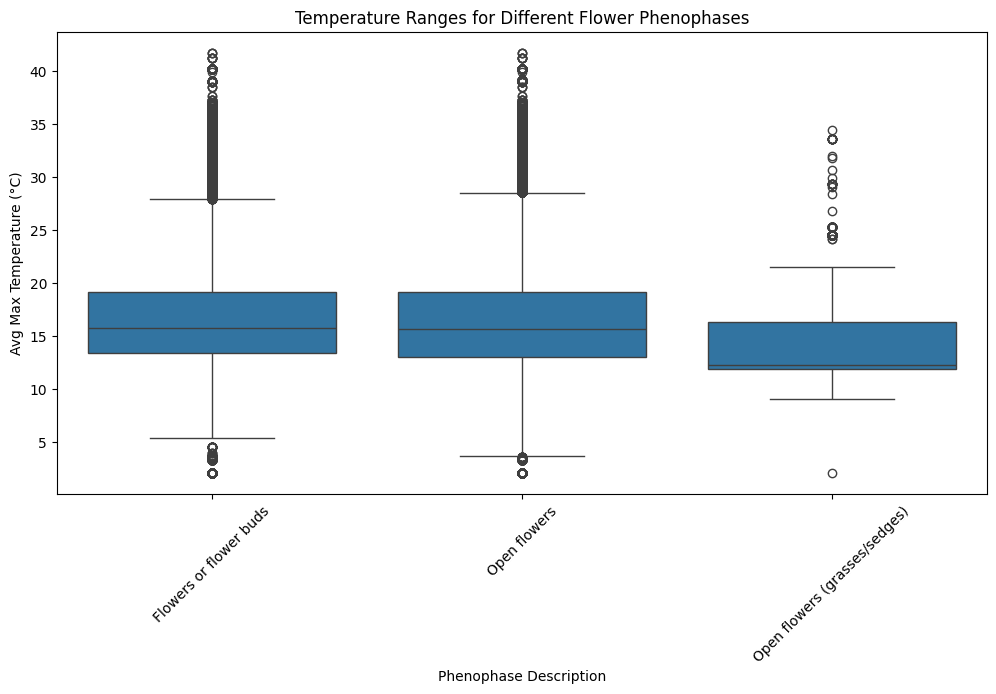

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_climate, x="Phenophase_Description", y="Avg_TMax")
plt.xticks(rotation=45)
plt.title("Temperature Ranges for Different Flower Phenophases")
plt.xlabel("Phenophase Description")
plt.ylabel("Avg Max Temperature (°C)")
plt.show()


This box plot displays the range of average maximum temperatures associated with three key flowering stages: “Flowers or flower buds,” “Open flowers,” and “Open flowers (grasses/sedges).” All three phenophases generally happen within a similar temperature range, with median values between 14°C - 17°C. However, grasses and sedges tend to bloom in slightly cooler conditions on average compared to other plants, as shown by its lower median and narrower interquartile range. The whiskers and outliers also indicate that “Flowers or flower buds” and “Open flowers” for non-grass plants can occur in a wider temperature range, including some much warmer environments, whereas grasses and sedges rarely flower at higher extremes. This suggests that plants that are not classified as grasses and sedges are more tolerant or responsive to higher temperatures, while grasses and sedges may prefer cooler and more consistent climatic conditions.

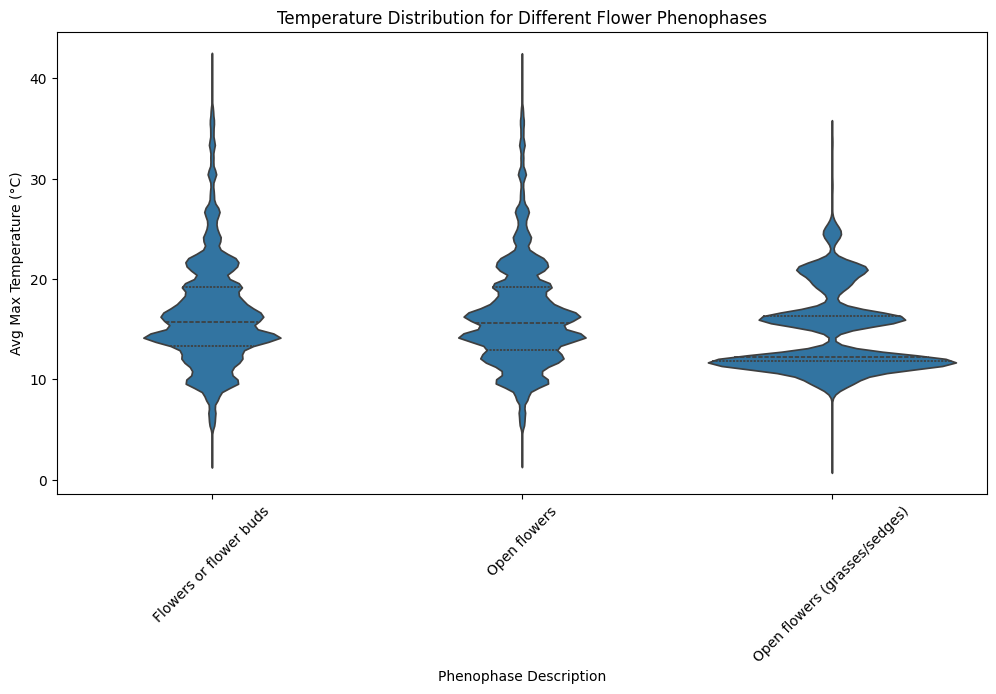

In [17]:
plt.figure(figsize=(12,6))
sns.violinplot(data=df_climate, x="Phenophase_Description", y="Avg_TMax", inner="quartile")
plt.xticks(rotation=45)
plt.title("Temperature Distribution for Different Flower Phenophases")
plt.xlabel("Phenophase Description")
plt.ylabel("Avg Max Temperature (°C)")
plt.show()

This violin plot shows maximum temperature with an emphasis on the density of observations. The “Open flowers” and “Flowers or flower buds” categories for non-grass plants both show bimodal or multimodal distributions, suggesting that these stages can occur under a wider range of temperature regimes and possibly reflect the behavior of multiple species with varying thermal preferences. In contrast, grasses / sedges display a more concentrated, unimodal distribution centered around cooler temperatures, reinforcing the idea that grasses and sedges are more sensitive to specific temperatures compared to other types of plants. This supports the interpretation from above, suggesting that while many flowering plants show flexibility in blooming under different temperatures, grasses and sedges appear less flexible, with tighter temperature constraints.

# Precipitation Impacts

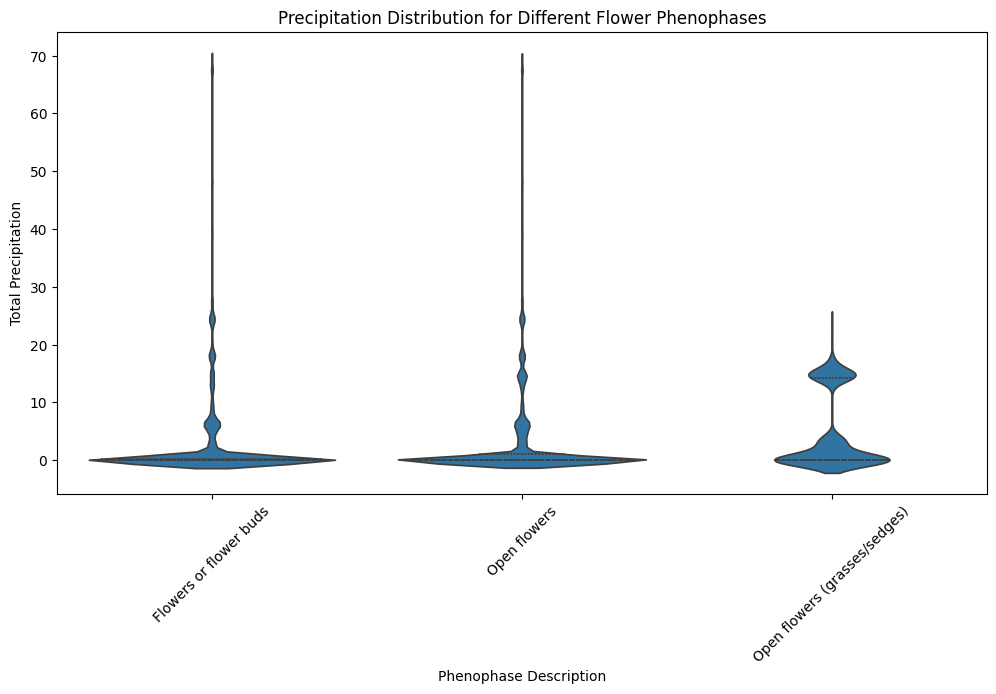

In [18]:
plt.figure(figsize=(12,6))
sns.violinplot(data=df_climate, x="Phenophase_Description", y="Total_Precipitation", inner="quartile")
plt.xticks(rotation=45)
plt.title("Precipitation Distribution for Different Flower Phenophases")
plt.xlabel("Phenophase Description")
plt.ylabel("Total Precipitation")
plt.show()

This violin plot shows that “Flowers or flower buds” and “Open flowers” for non-grass plants most commonly occur under lower precipitation conditions, with distributions tightly concentrated near zero and only occasionally flowering under wetter conditions. Grasses and sedges have a broader distribution skewed toward higher precipitation, indicating a stronger association with higher levels of precipitation. This suggests that while many flowering plants favor drier periods, grasses and sedges are more likely to bloom in wetter conditions, suggesting a difference in ecological preferences and potential responses to shifting precipitation patterns.

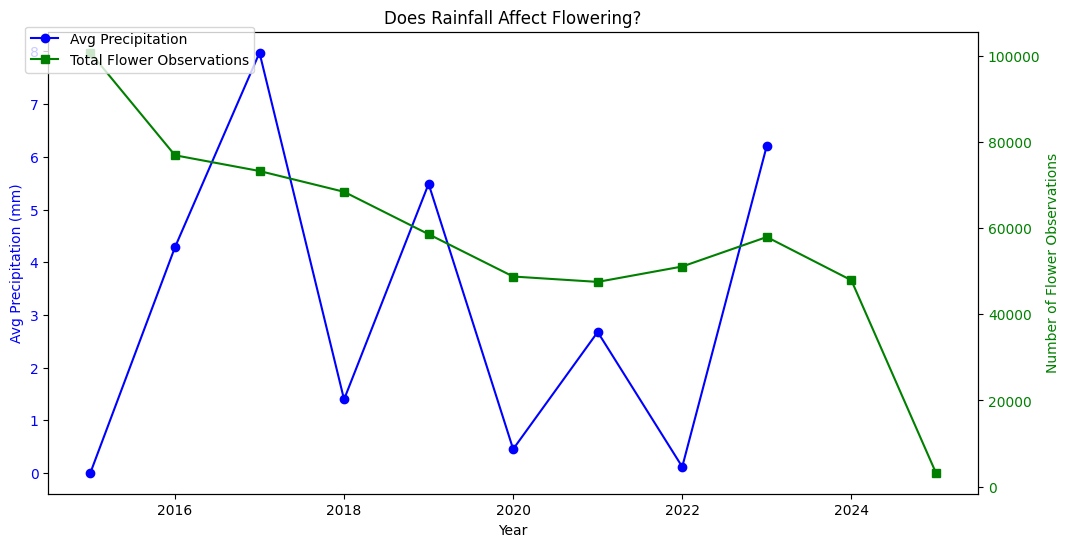

In [19]:
# Group by year
df_climate["Year"] = df_climate["Observation_Date"].dt.year
rainfall_trend = df_climate.groupby("Year")["Total_Precipitation"].mean()
bloom_count = df_climate.groupby("Year").size()

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Rainfall Trend
ax1.plot(rainfall_trend.index, rainfall_trend.values, marker="o", color="blue", label="Avg Precipitation")
ax1.set_ylabel("Avg Precipitation (mm)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Second Y-Axis for Bloom Count
ax2 = ax1.twinx()
ax2.plot(bloom_count.index, bloom_count.values, marker="s", color="green", label="Total Flower Observations")
ax2.set_ylabel("Number of Flower Observations", color="green")
ax2.tick_params(axis='y', labelcolor="green")

plt.title("Does Rainfall Affect Flowering?")
ax1.set_xlabel("Year")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()


This chart plots average annual precipitation measured in mm with the total number of flower observations per year. Over this period, there is a general decline in flower observations, dropping sharply after 2015 and generally following a declining trend (2025 shows a sharp drop in both precipitation and flower observations due to lack of data). Meanwhile, average precipitation fluctuates considerably with no consistent trend. There are spikes in 2017 and 2023, but significant dips in 2015 and 2022. The lack of a clear, direct correlation between the two lines suggests that precipitation alone may not be the primary cause of flowering activity. This suggests that while rainfall likely plays a role, other factors such as temperature, seasonal timing, or long-term climatic shifts may be more influential in determining overall flowering trends.

# Conclusion

Together, this analysis provides a look into how climate variables like temperature and precipitation influence flowering patterns over time. Seasonal blooming trends clearly peak in spring, with recent years suggesting a possible shift toward earlier bloom times that are potentially driven by warming temperatures. Temperature distributions indicate that most flowering phenophases occur within moderate ranges, though grasses and sedges favor slightly cooler and wetter conditions on average.

Precipitation appears to play a secondary, more variable role in flower blooming. While certain species of grasses and sedges may respond more directly to precipitaton levels, overall flowering activity shows weak and inconsistent correlations with precipitation. This suggests that temperature is a more reliable factor for flowering, with precipitation influencing blooming periods more selectively. These findings highlight the importance of monitoring phenological shifts in response to changes in climate, as even subtle changes in seasonal timing or environmental conditions can affect entire ecosystems.

There are some limitations to this analysis. Primarily, the data depends heavily on human observations and therefore cannot represent every single plant in California. The observation counts may vary significantly based on human activity and the number of contributors in a certain year or month.

This analysis could be expanded by focusing on a longer period of time, which was not possible here due to data constraints but most likely could be done using different sources or choosing to focus on a smaller area. A specific genus or species could be chosen for a deeper analysis on certain plants of interest. Another adjacent project could include insect data to see if certain species of insects and pollinators depend on flower blooming periods.